In [1]:
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast
import numpy as np
import pandas as pd 
#Libraries for NLP
import nltk

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

<b> Read Data from csv file </b>

In [2]:
df_train = pd.read_csv('train.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   Computer Science      20972 non-null  int64 
 4   Physics               20972 non-null  int64 
 5   Mathematics           20972 non-null  int64 
 6   Statistics            20972 non-null  int64 
 7   Quantitative Biology  20972 non-null  int64 
 8   Quantitative Finance  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB


In [4]:
df_train.shape

(20972, 9)

In [5]:
df_train.size

188748

<b> Test data </b>

In [6]:
df_test = pd.read_csv('test.csv')

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        8989 non-null   int64 
 1   TITLE     8989 non-null   object
 2   ABSTRACT  8989 non-null   object
dtypes: int64(1), object(2)
memory usage: 210.8+ KB


In [8]:
df_test.shape

(8989, 3)

In [9]:
df_test.size

26967

In [10]:
df_train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [11]:
df_test.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


<b> Data Preparation </b>

In [12]:
x = df_train.iloc[:,3:].sum()
rowsum = df_train.iloc[:,2:].sum(axis = 1)
no_of_label_count = 0

for sum in rowsum.items():
    if sum == 0:
        no_of_label_count += 1

print("Total number of articles = ",len(df_train))
print("Total number of articles without label = ",no_of_label_count)
print("total labels = ",x.sum())

Total number of articles =  20972
Total number of articles without label =  0
total labels =  26267


C:\Users\Dell\AppData\Local\Temp/ipykernel_7804/1970671481.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rowsum = df_train.iloc[:,2:].sum(axis = 1)


<b> Data Preparation </b>

In [13]:
train_null = df_train.isnull().sum()
print("Number of missing value in train data: ",train_null)

test_null = df_test.isnull().sum()
print("Number of missing value in test data: ", test_null)


print("\n")
print("train null data: ",train_null.sum())
print("test null data: ",test_null.sum())

Number of missing value in train data:  ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64
Number of missing value in test data:  ID          0
TITLE       0
ABSTRACT    0
dtype: int64


train null data:  0
test null data:  0


[6013, 5618, 5206, 8594, 587, 249]


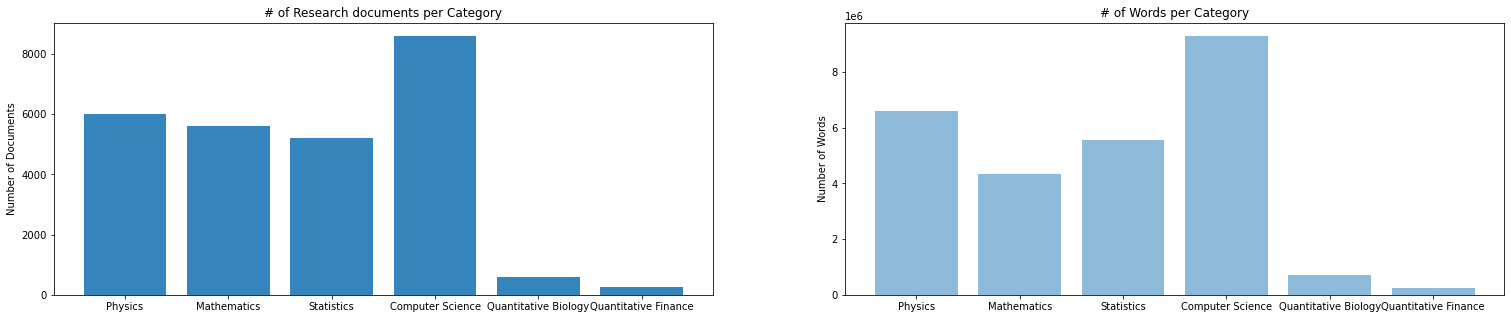

Amount of documents: 20972


In [14]:
classes = ['Physics','Mathematics','Statistics','Computer Science','Quantitative Biology','Quantitative Finance']
class_count = []
word_count = []
for c in classes:
    class_count.append(df_train[c].value_counts()[[1]][1])
    class_abstracts = df_train.where(df_train[c]==1)[['ABSTRACT']]
    word_count.append(pd.Series(class_abstracts.values.flatten()).str.len().sum())
print(class_count)


f, (ax1,ax2) = plt.subplots(1,2,figsize=(26,5))

ax1.bar(classes,class_count,align='center', alpha=0.9)
ax1.set_ylabel('Number of Documents')
ax2.bar(classes,word_count,align='center', alpha=0.5)
ax2.set_ylabel('Number of Words')
ax1.set_title('# of Research documents per Category')
ax2.set_title('# of Words per Category')

plt.show()
print("Amount of documents:", df_train.shape[0])

In [15]:
def autolabel(rects,labels):
# attach some text labels
    for rect,label in zip(rects,labels):
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2., 1.02*height, label,
              ha='center', va='bottom')
    return

In [16]:
def graph_viz(x,title,label):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12,12))
    ax = sns.barplot(x.index, x.values, alpha = 0.8) # adjust transparency (alpha) 
    plt.title(title,fontsize = 12)
    plt.ylabel(label,fontsize = 12)
    plt.xlabel('Label',fontsize=12)

  # Display count in each class over columns in a bar chart
    rects = ax.patches
    labels = x.values
    autolabel(rects,labels)

    plt.show()

Number of occurance of each document

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


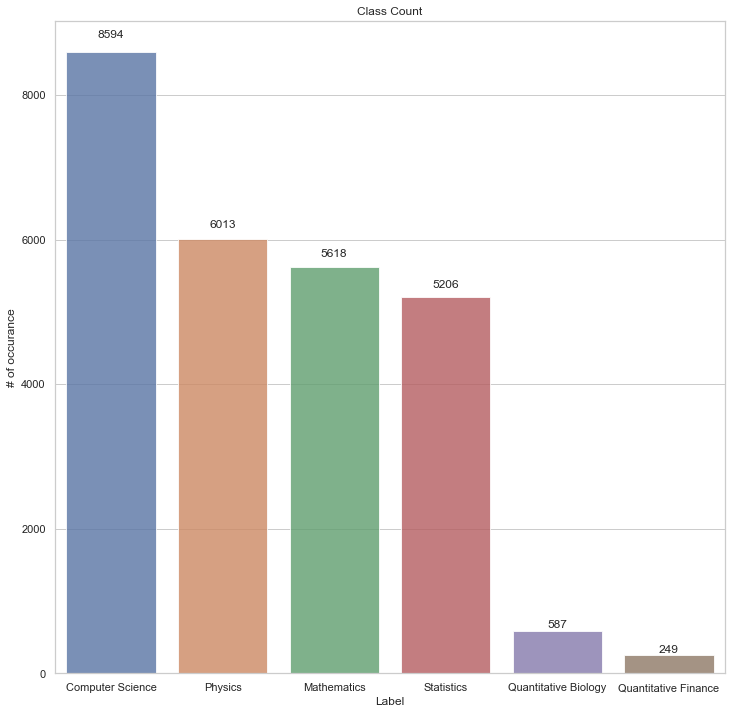

In [17]:
x = df_train.iloc[:,3:].sum()
graph_viz(x,title = 'Class Count',label='# of occurance')

No of Multiple tags per article

C:\Users\Dell\AppData\Local\Temp/ipykernel_7804/2318235666.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rowsum = df_train.iloc[:,2:].sum(axis = 1)
C:\Users\Dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


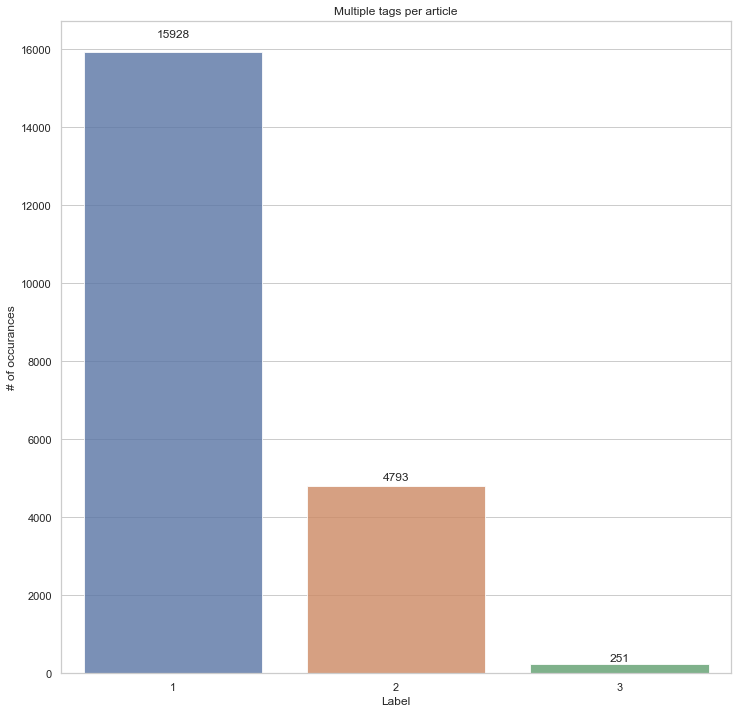

In [18]:
rowsum = df_train.iloc[:,2:].sum(axis = 1)
x = rowsum.value_counts() # Return a Series containing counts of unique values.
graph_viz(x,title = 'Multiple tags per article', label = '# of occurances')

In [19]:
train_text = df_train['ABSTRACT']
print(train_text.head())
print('--------------------------')
test_text = df_test['ABSTRACT']
print(test_text.head())

0      Predictive models allow subject-specific inf...
1      Rotation invariance and translation invarian...
2      We introduce and develop the notion of spher...
3      The stochastic Landau--Lifshitz--Gilbert (LL...
4      Fourier-transform infra-red (FTIR) spectra o...
Name: ABSTRACT, dtype: object
--------------------------
0      We present novel understandings of the Gamma...
1      Meteorites contain minerals from Solar Syste...
2      Frame aggregation is a mechanism by which mu...
3      Milky Way open clusters are very diverse in ...
4      Proving that a cryptographic protocol is cor...
Name: ABSTRACT, dtype: object


In [20]:
test_text.values

array(['  We present novel understandings of the Gamma-Poisson (GaP) model, a\nprobabilistic matrix factorization model for count data. We show that GaP can\nbe rewritten free of the score/activation matrix. This gives us new insights\nabout the estimation of the topic/dictionary matrix by maximum marginal\nlikelihood estimation. In particular, this explains the robustness of this\nestimator to over-specified values of the factorization rank, especially its\nability to automatically prune irrelevant dictionary columns, as empirically\nobserved in previous work. The marginalization of the activation matrix leads\nin turn to a new Monte Carlo Expectation-Maximization algorithm with favorable\nproperties.\n',
       '  Meteorites contain minerals from Solar System asteroids with different\nproperties (like size, presence of water, core formation). We provide new\nmid-IR transmission spectra of powdered meteorites to obtain templates of how\nmid-IR spectra of asteroidal debris would look l

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
def get_top_n_words(n_top_word ,test_data):
    vectorizer = TfidfVectorizer(stop_words = 'english') #initialize the vectorizer to remove stop words
    transformed_vectorizer = vectorizer.fit_transform(test_data)
    print(vectorizer.get_feature_names())
    print('\n')
    print(transformed_vectorizer.toarray())

    vectorized_total = np.sum(transformed_vectorizer, axis = 0) # column wise addition
    print("Vectorized total is: ",vectorized_total)
  # print(np.argsort(vectorized_total))
  # print(np.argsort(vectorized_total)[0,:])
    print(np.flip(np.argsort(vectorized_total)[0,:]))
  # print(np.flip(np.argsort(vectorized_total)[0,:],1))
  # print(np.flip(np.sort(vectorized_total)[0,:],1))
    print(np.flip(np.sort(vectorized_total)[0,:]))
  # print(vectorized_total.shape[1]) # column
  # print(vectorized_total.shape)

    word_indices = np.flip(np.argsort(vectorized_total)[0,:],1)
    print("word index is : ",word_indices)
    word_value = np.flip(np.sort(vectorized_total)[0,:],1)
  # print("Word Value is = ",word_value)
    print("Word Value is = ",word_value[0,:n_top_word].tolist()[0])
  
  # create a 2d array with 15 row and column and fill them with zero

    word_vector = np.zeros((n_top_word,vectorized_total.shape[1]))

    for i in range(n_top_word):
    # print(i,word_indices[0,i])
        word_vector[i,word_indices[0,i]] = 1

  # print(word_vector)
  # print(vectorizer.inverse_transform(word_vector))

    inverse_vectorizer = vectorizer.inverse_transform(word_vector)
    print("inverse of vector is : ",inverse_vectorizer)
    words = [word[0] for word in inverse_vectorizer]
    print(words)
    return(words, word_value[0,:n_top_word].tolist()[0])

In [22]:
# get the top n words from the text by converting them into vector
'''
function gets a tuple of top n words and their count.
'''
print(test_text)
# get_top_n_words(n_top_word = 15,test_data = test_text)
words, words_val = get_top_n_words(n_top_word = 15,test_data = test_text.values)

0         We present novel understandings of the Gamma...
1         Meteorites contain minerals from Solar Syste...
2         Frame aggregation is a mechanism by which mu...
3         Milky Way open clusters are very diverse in ...
4         Proving that a cryptographic protocol is cor...
                              ...                        
8984      We approach the problem of implementing mixe...
8985      In the theory of Markov decision processes (...
8986      GeneVis is a web-based tool to visualize com...
8987      This paper quantifies the effect of speed ca...
8988      We show that the vertices and edges of a $d$...
Name: ABSTRACT, Length: 8989, dtype: object
['00', '000', '0000', '00000', '0000033', '0000055', '0001', '0002', '00069', '0007', '000deg', '000k', '000x', '001', '002', '0020', '0025', '003', '004', '00422', '005', '00528', '006', '0062', '00759', '008', '0091', '00938', '009msun', '01', '010', '010801', '011125', '013', '01355', '01434', '015', '01611', '019

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Vectorized total is:  [[0.62550936 7.6499338  0.40381812 ... 0.09767873 0.11170759 0.24392218]]
[[20952  8752 18604 ... 20748 14448 28328]]
[[1.57950491e+02 1.57658497e+02 1.23726373e+02 ... 4.32708480e-02
  3.27420827e-02 3.27420827e-02]]
word index is :  [[20952  8752 18604 ... 20748 14448 28328]]
Word Value is =  [157.95049092280587, 157.65849745578328, 123.7263731392546, 116.57020478267295, 113.17447521022558, 110.66603869386957, 110.01299194303535, 107.92127715884567, 106.71887737628468, 106.3003666989855, 104.17479830301885, 103.3034621267513, 101.30291578922221, 93.52531683782637, 92.50064173633761]
inverse of vector is :  [array(['model'], dtype='<U28'), array(['data'], dtype='<U28'), array(['learning'], dtype='<U28'), array(['based'], dtype='<U28'), array(['time'], dtype='<U28'), array(['method'], dtype='<U28'), array(['pro

C:\Users\Dell\AppData\Local\Temp/ipykernel_7804/656171559.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation='vertical') # makes the word vertical


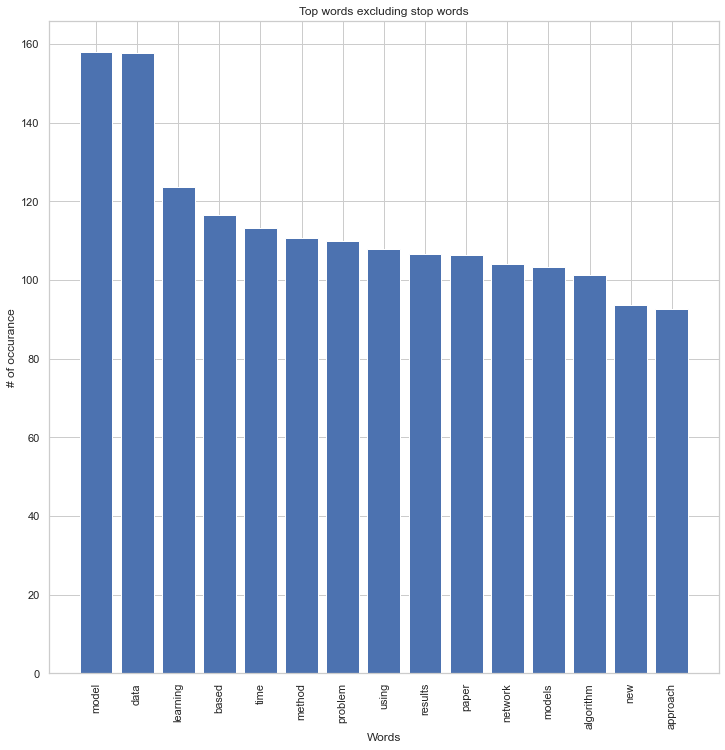

In [23]:
sns.set_theme(style="whitegrid")
fig,ax = plt.subplots(figsize=(12,12)) # this is needed when you are using axis.bar
ax.bar(words,words_val) 
ax.set_xticklabels(words, rotation='vertical') # makes the word vertical
plt.title('Top words excluding stop words',fontsize = 12)
plt.ylabel('# of occurance',fontsize = 12)
plt.xlabel('Words',fontsize=12)
plt.show()

In [24]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
# import these modules
from nltk.stem import WordNetLemmatizer
  
lemmatizer = nltk.WordNetLemmatizer()
class CountVectorizer_lemmatizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(CountVectorizer_lemmatizer, self).build_analyzer()
        return lambda doc:(lemmatizer.lemmatize(w) for w in analyzer(doc))

In [26]:

text = list(train_text)

tf_vectorizer = CountVectorizer_lemmatizer(decode_error='ignore', max_df = 0.95,min_df=2,stop_words='english') # applying count vectorizer

tf = tf_vectorizer.fit_transform(text)


In [27]:
# play around with this
n_topics = 10

In [28]:
lda = LatentDirichletAllocation(n_components = n_topics, max_iter=5, learning_method='online',learning_offset=50., random_state=0)

lda.fit(tf)

# making LDA TOP MATRIX USING CORPUS TF
lda_topic_modelling = lda.fit_transform(tf)

In [29]:
lda_topic_modelling

array([[5.58676962e-04, 5.58775291e-04, 4.66799517e-02, ...,
        5.58701095e-04, 2.19046296e-01, 3.94864169e-02],
       [2.22246883e-03, 2.22285985e-03, 4.69877758e-01, ...,
        2.22448182e-03, 2.99481687e-01, 2.22296526e-03],
       [1.92309257e-03, 6.89229070e-01, 1.92332416e-03, ...,
        1.92322155e-03, 2.95385512e-01, 1.92319686e-03],
       ...,
       [9.26006316e-04, 5.27832965e-02, 7.99253118e-02, ...,
        9.25979368e-04, 9.26100887e-04, 9.26166377e-04],
       [1.60900649e-02, 9.24097221e-02, 8.69623081e-04, ...,
        4.32471203e-02, 7.02479000e-01, 8.69701095e-04],
       [1.33365703e-03, 1.33359950e-03, 1.33343830e-03, ...,
        1.33350546e-03, 1.28475234e-01, 1.33351898e-03]])

In [30]:
def get_keys(topic_matrix): 
    keys = topic_matrix.argmax(axis = 1).tolist()
    print("length of the keys is: ",len(keys))
    return keys

In [31]:
from collections import Counter
def key_to_count(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [32]:
lda_keys = get_keys(lda_topic_modelling)
print("keys: ",lda_keys)

length of the keys is:  20972
keys:  [5, 2, 1, 1, 5, 7, 6, 9, 9, 5, 0, 9, 9, 1, 9, 1, 6, 1, 5, 9, 9, 9, 8, 3, 1, 1, 8, 1, 8, 1, 2, 1, 5, 5, 2, 8, 8, 5, 6, 5, 8, 8, 9, 8, 5, 5, 1, 9, 5, 5, 5, 1, 3, 5, 1, 5, 9, 5, 5, 1, 5, 8, 9, 9, 9, 5, 1, 1, 5, 1, 8, 9, 4, 1, 9, 8, 5, 9, 1, 9, 5, 5, 0, 7, 5, 9, 9, 7, 9, 8, 6, 9, 5, 9, 9, 5, 2, 1, 1, 9, 5, 8, 5, 9, 1, 9, 1, 5, 5, 5, 9, 5, 1, 9, 5, 3, 5, 5, 5, 8, 5, 5, 6, 9, 2, 9, 0, 8, 1, 3, 5, 9, 1, 1, 5, 6, 9, 9, 5, 5, 5, 9, 1, 1, 1, 9, 1, 1, 3, 6, 5, 1, 1, 1, 1, 9, 1, 5, 8, 8, 5, 9, 1, 1, 8, 1, 6, 5, 5, 1, 3, 5, 8, 0, 5, 5, 5, 2, 5, 0, 9, 9, 1, 1, 5, 9, 5, 1, 5, 9, 9, 3, 2, 5, 1, 5, 5, 5, 9, 1, 9, 1, 5, 5, 5, 6, 1, 1, 9, 1, 5, 5, 7, 5, 8, 6, 5, 9, 1, 5, 2, 6, 5, 8, 5, 1, 6, 8, 3, 5, 9, 8, 1, 1, 0, 3, 9, 5, 9, 9, 9, 1, 9, 8, 9, 5, 5, 8, 1, 5, 1, 5, 3, 5, 5, 2, 8, 5, 8, 5, 5, 5, 9, 8, 8, 1, 5, 9, 1, 5, 8, 5, 1, 5, 3, 1, 5, 8, 5, 5, 8, 9, 1, 1, 8, 8, 2, 1, 9, 9, 5, 9, 9, 5, 1, 9, 1, 5, 5, 9, 5, 3, 8, 1, 9, 5, 5, 8, 1, 1, 6, 1, 5, 5, 9, 1, 5, 5, 5, 8, 1,

In [33]:
def get_top_n_words(n, keys, document_term_matrix, cv):
    top_word_indices = []

    for topic in range(n_topics): # go from 0 to 24
        temp_vector_sum = 0
        # print(len(keys))  # 20972
        # print(keys)
        for i in range(len(keys)): # go from 0 to 20971
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = cv.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [34]:
n_top_words = 25
top_n_words = get_top_n_words(n_top_words, lda_keys, tf, tf_vectorizer)

In [35]:
for i in range(len(top_n_words)):
    print("Topic {}: \n".format(i+1), top_n_words[i]+"\n")

Topic 1: 
 energy power paper model market price cost resource system network based high technology time data result user performance computing design using application approach service present

Topic 2: 
 result problem function space graph paper equation time mathbb set group prove solution case number study theory model class algebra point non algorithm bound property

Topic 3: 
 network training neural learning adversarial deep model image method gan generative result trained data performance task using propose end input based proposed layer speech classification

Topic 4: 
 language paper logic problem program model result based present theory analysis used work algorithm proof code system type semantics software order using article tool set

Topic 5: 
 cell mutation model tumor game gene tree cause time cop pathway dna protein player population effect specie sequence result phylogeny biofilms cluster rate coalition study

Topic 6: 
 model data network method learning based approa

In [36]:
from sklearn.manifold import TSNE
tnse_lda_model = TSNE(n_components=2, perplexity=50, early_exaggeration=4.0, learning_rate=100, n_iter=2000, metric='euclidean', init='random', verbose=0, random_state=0)
tnse_lda_vector = tnse_lda_model.fit_transform(lda_topic_modelling)

In [37]:
k = 3
top_k_words_lda = get_top_n_words(k,lda_keys,tf,tf_vectorizer)
top_k_words_lda

['energy power paper',
 'result problem function',
 'network training neural',
 'language paper logic',
 'cell mutation model',
 'model data network',
 'star galaxy mass',
 'group mathbb mathfrak',
 'method algorithm problem',
 'state model field']

In [50]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [51]:
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys,tnse_lda_vector)

In [41]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f" ])
colormap = colormap[:n_topics]
print(colormap)

['#1f77b4' '#aec7e8' '#ff7f0e' '#ffbb78' '#2ca02c' '#98df8a' '#d62728'
 '#ff9896' '#9467bd' '#c5b0d5']


In [52]:
lda_mean_topic_vectors

[array([-42.47711  ,  -4.6432347], dtype=float32),
 array([-6.8304343,  4.4781847], dtype=float32),
 array([ 19.816324, -19.371805], dtype=float32),
 array([-71.227875 ,  -3.2417893], dtype=float32),
 array([19.543346, 15.613205], dtype=float32),
 array([-19.36995, -28.20778], dtype=float32),
 array([ 42.60435, -36.90389], dtype=float32),
 array([-68.82101,  64.63667], dtype=float32),
 array([-8.750862, 41.752556], dtype=float32),
 array([57.60951, 32.93023], dtype=float32)]

In [49]:
tnse_lda_vector

array([[-17.659237 ,   3.2184381],
       [ 18.574472 ,   1.427666 ],
       [-49.218727 ,  53.78485  ],
       ...,
       [ -5.7061543, -59.24711  ],
       [ -9.313498 ,  63.62772  ],
       [-77.7617   , -28.208055 ]], dtype=float32)

In [53]:


#Creating the t-SNE plot
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=600, plot_height=600)
plot.scatter(x=tnse_lda_vector[:,0], y=tnse_lda_vector[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_k_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [46]:
list(train_text)

["  Predictive models allow subject-specific inference when analyzing disease\nrelated alterations in neuroimaging data. Given a subject's data, inference can\nbe made at two levels: global, i.e. identifiying condition presence for the\nsubject, and local, i.e. detecting condition effect on each individual\nmeasurement extracted from the subject's data. While global inference is widely\nused, local inference, which can be used to form subject-specific effect maps,\nis rarely used because existing models often yield noisy detections composed of\ndispersed isolated islands. In this article, we propose a reconstruction\nmethod, named RSM, to improve subject-specific detections of predictive\nmodeling approaches and in particular, binary classifiers. RSM specifically\naims to reduce noise due to sampling error associated with using a finite\nsample of examples to train classifiers. The proposed method is a wrapper-type\nalgorithm that can be used with different binary classifiers in a diag

In [47]:
doc_topic = lda.transform(tf)

# check for 20 documents
for n in range(20):
  # print(doc_topic[n])
  topic_most_pr = doc_topic[n].argmax()
  # print(topic_most_pr)
  print("Document #{} - topic: {}\n".format(n,topic_most_pr))
  # this means document 1 belongs to topic 5 which seems to be like Quantitative Biology 

Document #0 - topic: 5

Document #1 - topic: 2

Document #2 - topic: 1

Document #3 - topic: 1

Document #4 - topic: 5

Document #5 - topic: 7

Document #6 - topic: 6

Document #7 - topic: 9

Document #8 - topic: 9

Document #9 - topic: 5

Document #10 - topic: 0

Document #11 - topic: 9

Document #12 - topic: 9

Document #13 - topic: 1

Document #14 - topic: 9

Document #15 - topic: 1

Document #16 - topic: 6

Document #17 - topic: 1

Document #18 - topic: 5

Document #19 - topic: 9



In [54]:
doc_topic_df = pd.DataFrame(data=doc_topic)
doc_topic_df

,0,1,2,3,4,5,6,7,8,9
0,0.000559,0.000559,0.046680,0.155668,0.020155,0.516730,0.000559,0.000559,0.219046,0.039486
1,0.002222,0.002223,0.469878,0.002223,0.002222,0.215080,0.002223,0.002224,0.299482,0.002223
2,0.001923,0.689229,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.295386,0.001923
3,0.001588,0.571966,0.001588,0.001588,0.001587,0.001588,0.001588,0.001587,0.230501,0.186420
4,0.001235,0.001235,0.112500,0.001235,0.011195,0.525566,0.163221,0.015370,0.167209,0.001235
...,...,...,...,...,...,...,...,...,...,...
20967,0.000855,0.024481,0.142635,0.100983,0.000855,0.695277,0.000855,0.000855,0.000855,0.032350
20968,0.039384,0.001220,0.001220,0.001220,0.001220,0.001220,0.001220,0.013319,0.037031,0.902948
20969,0.000926,0.052783,0.079925,0.013801,0.070857,0.742548,0.036381,0.000926,0.000926,0.000926
20970,0.016090,0.092410,0.000870,0.000870,0.010376,0.094989,0.037799,0.043247,0.702479,0.000870


In [55]:
for (columnName, columnData) in doc_topic_df.iteritems():
    print(columnName, columnData)

0 0        0.000559
1        0.002222
2        0.001923
3        0.001588
4        0.001235
           ...   
20967    0.000855
20968    0.039384
20969    0.000926
20970    0.016090
20971    0.001334
Name: 0, Length: 20972, dtype: float64
1 0        0.000559
1        0.002223
2        0.689229
3        0.571966
4        0.001235
           ...   
20967    0.024481
20968    0.001220
20969    0.052783
20970    0.092410
20971    0.001334
Name: 1, Length: 20972, dtype: float64
2 0        0.046680
1        0.469878
2        0.001923
3        0.001588
4        0.112500
           ...   
20967    0.142635
20968    0.001220
20969    0.079925
20970    0.000870
20971    0.001333
Name: 2, Length: 20972, dtype: float64
3 0        0.155668
1        0.002223
2        0.001923
3        0.001588
4        0.001235
           ...   
20967    0.100983
20968    0.001220
20969    0.013801
20970    0.000870
20971    0.365578
Name: 3, Length: 20972, dtype: float64
4 0        0.020155
1        0.002222
2     

In [56]:
for (columnName, columnData) in doc_topic_df.iteritems():
    print(columnData.values) # first column, second column and so on.
    print("\n")
    print(pd.DataFrame(data=columnData.values).sort_values(by=0, ascending=False))

[0.00055868 0.00222247 0.00192309 ... 0.00092601 0.01609006 0.00133366]


              0
10332  0.685034
82     0.674025
2931   0.659645
11745  0.635322
1301   0.627058
...         ...
9306   0.000510
16504  0.000500
15946  0.000498
10061  0.000474
19445  0.000431

[20972 rows x 1 columns]
[5.58775291e-04 2.22285985e-03 6.89229070e-01 ... 5.27832965e-02
 9.24097221e-02 1.33359950e-03]


              0
347    0.992856
1697   0.991088
4577   0.990999
4677   0.989653
1228   0.989155
...         ...
17596  0.000529
11905  0.000526
10608  0.000526
10033  0.000521
11528  0.000516

[20972 rows x 1 columns]
[0.04667995 0.46987776 0.00192332 ... 0.07992531 0.00086962 0.00133344]


              0
30     0.845870
407    0.664686
17317  0.643276
13324  0.641816
4328   0.608954
...         ...
16504  0.000500
15946  0.000498
10061  0.000474
11502  0.000474
19445  0.000431

[20972 rows x 1 columns]
[0.15566757 0.00222255 0.0019232  ... 0.01380118 0.0008697  0.36557811]


              0
3271   0.

In [57]:
for (columnName, columnData) in doc_topic_df.iteritems():
    n = 5
    print('Topic #', columnName)
    sorted_topic = pd.DataFrame(data=columnData.values).sort_values(by=0, ascending=False)
    sorted_topic.columns = [columnName]
    print(sorted_topic[:n])
    
    # store IDs and titles of top articles in a dataframe
    ids = sorted_topic[:n].index
    print("\n")

Topic # 0
              0
10332  0.685034
82     0.674025
2931   0.659645
11745  0.635322
1301   0.627058


Topic # 1
             1
347   0.992856
1697  0.991088
4577  0.990999
4677  0.989653
1228  0.989155


Topic # 2
              2
30     0.845870
407    0.664686
17317  0.643276
13324  0.641816
4328   0.608954


Topic # 3
              3
3271   0.935705
5527   0.933750
10675  0.909995
15554  0.899992
7786   0.877689


Topic # 4
             4
1727  0.570473
1786  0.450994
919   0.394047
9402  0.390371
72    0.389014


Topic # 5
              5
11744  0.993232
15477  0.993180
4767   0.992240
3248   0.991508
1739   0.991508


Topic # 6
              6
6763   0.983332
2592   0.953883
12385  0.953553
4988   0.951272
166    0.943749


Topic # 7
              7
14521  0.935710
5846   0.929970
1847   0.924990
17621  0.887473
13271  0.778042


Topic # 8
              8
12075  0.981630
13820  0.960414
10278  0.953807
392    0.932229
214    0.906696


Topic # 9
             9
1743  0.994117


5    7861
1    4880
9    3639
8    2369
6    1183
3     459
0     235
7     180
2     148
4      18
dtype: int64

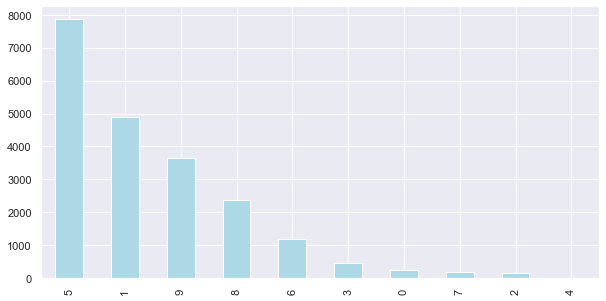

In [58]:
#plotting the distribution of documents over each topic
sns.set(rc={'figure.figsize':(10,5)})
doc_topic_df.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

#store the distributions in a dataframe
distribution = doc_topic_df.idxmax(axis=1).value_counts()
distribution